In [103]:
import random
from pprint import pp
from abc import ABC, abstractmethod
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import itertools as it
from functools import total_ordering
from typing import List, Tuple, Dict, Optional, Union, Callable
from enum import Enum

In [55]:
# simulation parameters
NUM_PAYLOADS = 10**3
NUM_PAYLOADS_TO_TRY_BEFORE_GIVING_UP = NUM_PAYLOADS * 10 # if the number of received packets exceeds this number, the simulation for the current configuration is aborted
PAYLOAD_SIZE = 128  # bits

@total_ordering
class AesImplementation(Enum):
    Software = 0
    Hardware = 1

    def __lt__(self, other: 'AesImplementation') -> bool:
        if self.__class__ is other.__class__:
            return self.value < other.value
        return NotImplemented


@dataclass
class Configuration:
    energy: float # mJ
    time: float # seconds
    payload_size: int # bits
    aes_used: bool # True if {soft,hard}ware AES is used
    hamming_used: bool # True if Hamming (8,4) encoding is used
    aes_implementation: Optional[AesImplementation] = None # {soft,hard}ware AES

    def __str__(self) -> str:
        return f'{self.energy} mJ, {self.time} s, {self.payload_size} bits, AES: {self.aes_used}, Hamming: {self.hamming_used}'

configurations: dict[str, Configuration] = {
    'base': Configuration(
        energy=0.942507, # mJ
        time=0.001312255859, # seconds
        payload_size=PAYLOAD_SIZE,
        aes_used=False,
        hamming_used=False,

    ),
    'with_software_aes': Configuration(
        energy=0.960341, # mJ
        time=0.004791259766, # seconds
        payload_size=PAYLOAD_SIZE,
        aes_used=True,
        hamming_used=False,
        aes_implementation=AesImplementation.Software,
    ),
    'with_hardware_aes': Configuration(
        energy=0.945887, # mJ
        time=0.001739501953,    # seconds
        payload_size=PAYLOAD_SIZE,
        aes_used=True,
        hamming_used=False,
        aes_implementation=AesImplementation.Hardware,
    ),
    'with_software_aes_and_8_4_hamming': Configuration(
        energy=0.994701, # mJ
        time=0.005065917969, # seconds
        payload_size=PAYLOAD_SIZE * 2,
        aes_used=True,
        hamming_used=True,
        aes_implementation=AesImplementation.Software,
    ),
    'with_hardware_aes_and_8_4_hamming': Configuration(
        energy=0.979921, # mJ
        time=0.002014160156,    # seconds
        payload_size=PAYLOAD_SIZE * 2,
        aes_used=True,
        hamming_used=True,
        aes_implementation=AesImplementation.Hardware,
    ),
}

pp(configurations)

{'base': Configuration(energy=0.942507,
                       time=0.001312255859,
                       payload_size=128,
                       aes_used=False,
                       hamming_used=False,
                       aes_implementation=None),
 'with_software_aes': Configuration(energy=0.960341,
                                    time=0.004791259766,
                                    payload_size=128,
                                    aes_used=True,
                                    hamming_used=False,
                                    aes_implementation=<AesImplementation.Software: 0>),
 'with_hardware_aes': Configuration(energy=0.945887,
                                    time=0.001739501953,
                                    payload_size=128,
                                    aes_used=True,
                                    hamming_used=False,
                                    aes_implementation=<AesImplementation.Hardware: 1>),
 'with_software_aes_and_

In [3]:


# trait NoiseModel {
#     fn apply_noise(&self, payload: &[u8]) -> Vec<u8>;
#     fn get_name(&self) -> String;
# }


class NoiseModel(ABC):
    @abstractmethod
    def apply_noise(self, payload: list[int]) -> list[int]:
        pass

    @abstractmethod
    def get_name(self) -> str:
        pass



class BinarySymmetricChannel(NoiseModel):
    """
    Binary Symmetric Channel (BSC) with probability p of bit flip.
    """
    def __init__(self, p: float):
        assert 0 <= p <= 1, 'p must be between 0 and 1, but is {}'.format(p)
        self.p = p

    def apply_noise(self, payload: list[int]) -> list[int]:
        length = len(payload)
        assert length > 0, 'payload must not be empty, but is {}'.format(payload)

        noise = [1 if random.random() < self.p else 0 for _ in range(length)] # [1,0,1,1,0,0,0,1,1,0]

        return [a ^ b for a, b in zip(payload, noise)]

    def get_name(self) -> str:
        return 'BSC(p={})'.format(self.p)
    

class GilbertElliotChannel(NoiseModel):
    def __init__(self, p: float, r: float, initial_state_is_good: bool):
        assert 0 <= p <= 1, 'p must be between 0 and 1, but is {}'.format(p)
        assert 0 <= r <= 1, 'r must be between 0 and 1, but is {}'.format(r)
        self.p = p
        self.r = r
        self.state_is_good = initial_state_is_good


    def apply_noise(self, payload: list[int]) -> list[int]:
        length = len(payload)
        assert length > 0, 'payload must not be empty, but is {}'.format(payload)

        noisy_payload: list[int] = []
        for bit in payload:
            random_number: float = random.random()
            if self.state_is_good:
                if random_number < self.p:
                    self.state_is_good = False
            else:
                if random_number < self.r:
                    self.state_is_good = True

            noisy_payload.append(bit ^ 1 if not self.state_is_good else bit)

        return noisy_payload
            

    def get_name(self) -> str:
        return 'Gilbert-Elliot Model(p={},r={})'.format(self.p, self.r)



noise_models: list[NoiseModel] =  [
    # BinarySymmetricChannel(0.1), # 10% bit error rate
    BinarySymmetricChannel(0.01), # 1% bit error rate
    # BinarySymmetricChannel(0.001), # 0.1% bit error rate
    BinarySymmetricChannel(0.0001), 
    # BinarySymmetricChannel(0.00001),
    
    # p, r, initial_state_is_good
    # GilbertElliotChannel(p=0.01, r=0.001, initial_state_is_good=True),
    GilbertElliotChannel(p=0.01, r=0.5, initial_state_is_good=True),
    GilbertElliotChannel(p=0.001, r=0.1, initial_state_is_good=True),
    # GilbertElliotChannel(0.001, 0.3, True),
    # GilbertElliotChannel(0.0001, 0.1, True),
] 

In [4]:

class OrderingScheme(ABC):
    @abstractmethod
    def get_name(self) -> str:
        pass

    @abstractmethod
    def order(self, payload: list[int]) -> list[int]:
        pass

    @abstractmethod
    def reorder(self, payload: list[int]) -> list[int]:
        pass


class NoOrdering(OrderingScheme):
    def get_name(self) -> str:
        return 'No Ordering'

    def order(self, payload: list[int]) -> list[int]:
        return payload

    def reorder(self, payload: list[int]) -> list[int]:
        return payload



# NO INTERLEAVE
# 0, 1, 2, 3, 4, 5, 6, 7,   | 8, 9, 10, 11, 12, 13, 14, 15
# 16, 17, 18, 19, 20, 21,   | 22, 23, 24, 25, 26, 27, 28, 29, 30, 31
# 32, 33, 34, 35, 36, 37,   | 38, 39, 40, 41, 42, 43, 44, 45, 46, 47
# 48, 49, 50, 51, 52, 53,   | 54, 55, 56, 57, 58, 59, 60, 61, 62, 63
# 64, 65, 66, 67, 68, 69,   | 70, 71, 72, 73, 74, 75, 76, 77, 78, 79
# 80, 81, 82, 83, 84, 85,   | 86, 87, 88, 89, 90, 91, 92, 93, 94, 95
# 96, 97, 98, 99, 100, 101, | 102, 103, 104, 105, 106, 107, 108, 109, 110, 111
# 112, 113, 114, 115, 116,  | 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127


# WITH INTERLEAVE
# 0, 8, 16, 24, 32, 40, 48, 56,  | 64, 72, 80, 88, 96, 104, 112, 120
# 1, 9, 17, 25, 33, 41, 49, 57,  | 65, 73, 81, 89, 97, 105, 113, 121
# 2, 10, 18, 26, 34, 42, 50, 58, | 66, 74, 82, 90, 98, 106, 114, 122
# 3, 11, 19, 27, 35, 43, 51, 59, | 67, 75, 83, 91, 99, 107, 115, 123
# 4, 12, 20, 28, 36, 44, 52, 60, | 68, 76, 84, 92, 100, 108, 116, 124
# 5, 13, 21, 29, 37, 45, 53, 61, | 69, 77, 85, 93, 101, 109, 117, 125
# 6, 14, 22, 30, 38, 46, 54, 62, | 70, 78, 86, 94, 102, 110, 118, 126
# 7, 15, 23, 31, 39, 47, 55, 63, | 71, 79, 87, 95, 103, 111, 119, 127
class OctetInterleaving(OrderingScheme):
    def get_name(self) -> str:
        return 'Octet Interleaving'

    def order(self, payload: list[int]) -> list[int]:
        assert len(payload) % 8 == 0, 'payload must be a multiple of 8, but is {}'.format(payload)
     
        return np.array(payload) \
            .reshape((len(payload) // 8, 8)) \
            .transpose() \
            .reshape(-1) \
            .tolist()

     
    def reorder(self, payload: list[int]) -> list[int]:
        assert len(payload) % 8 == 0, 'payload must be a multiple of 8, but is {}'.format(payload)

        return np.array(payload) \
            .reshape((8, len(payload) // 8)) \
            .transpose() \
            .reshape(-1) \
            .tolist()

ordering_schemes: list[OrderingScheme] = [
    NoOrdering(),
    OctetInterleaving(),
]


ns = np.arange(0, 128, 1)
print(ns)
octet = OctetInterleaving()
print(octet.order(ns))
print(octet.reorder(octet.order(ns)))




[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 1, 9, 17, 25, 33, 41, 49, 57, 65, 73, 81, 89, 97, 105, 113, 121, 2, 10, 18, 26, 34, 42, 50, 58, 66, 74, 82, 90, 98, 106, 114, 122, 3, 11, 19, 27, 35, 43, 51, 59, 67, 75, 83, 91, 99, 107, 115, 123, 4, 12, 20, 28, 36, 44, 52, 60, 68, 76, 84, 92, 100, 108, 116, 124, 5, 13, 21, 29, 37, 45, 53, 61, 69, 77, 85, 93, 101, 109, 117, 125, 6, 14, 22, 30, 38, 46, 54, 62, 70, 78, 86, 94, 102, 110, 118, 126, 7, 15, 23, 31, 

In [41]:

@dataclass
class SimulationResult:
    name: str
    total_energy: float
    total_cumulative_energy_over_payloads: list[float]
    total_time: float
    total_cumulative_time_over_payloads: list[float]
    payload_size: int
    num_payloads: int
    configuration: Configuration
    # aes_encryption: bool
    # hamming_8_4_encoding: bool
    noise_model: NoiseModel
    ordering_scheme: OrderingScheme
    concede: bool = False

In [59]:
gen_random_payload = lambda size: [random.randint(0, 1) for _ in range(size)]

simulation_results: list[SimulationResult] = []

pbar0 = tqdm(total=len(noise_models) * len(ordering_schemes) * len(configurations.keys()), desc='configurations')

for name, configuration in configurations.items():
    for noise_model in noise_models:
        for ordering_scheme in ordering_schemes:
            pbar0.set_description('configurations: {} noise model: {} ordering scheme: {}'.format(name, noise_model.get_name(), ordering_scheme.get_name()))
            pbar0.update(1)

            pbar1 = tqdm(total=NUM_PAYLOADS, desc='{} - {}'.format(name, noise_model.get_name()))

            # print(f'configuration: {name}, noise model: {noise_model.get_name()}, ordering scheme: {ordering_scheme.get_name()}', end='\r')

            total_energy: float = 0.0
            total_time: float = 0.0
            cummulitive_energy_used: list[float] = []
            cummulitive_time_used: list[float] = []

            payloads_successfully_received = 0
            payloads_received = 0

            payload_size: int = configuration.payload_size
            max_bit_error_tolerance_per_byte = 1 if configuration.hamming_used else 0

            while payloads_successfully_received < NUM_PAYLOADS and payloads_received < NUM_PAYLOADS_TO_TRY_BEFORE_GIVING_UP:
                payloads_received += 1
                total_energy += configuration.energy
                total_time += configuration.time

                payload: list[int] = gen_random_payload(payload_size)
                # simulate ordering of the bits in the payload
                ordered_payload: list[int] = ordering_scheme.order(payload)
                # simulate applying the noise model
                noisy_payload: list[int] = noise_model.apply_noise(ordered_payload)
                # simulate reordering of the bits in the payload
                reordered_payload: list[int] = ordering_scheme.reorder(noisy_payload)

                # based on the configuration, check if the payload is too corrupted to be received
                # and if it is, discard it and generate a new one
                # if it is not, increment the counter
                payload_diff: list[int] = [a ^ b for a, b in zip(payload, reordered_payload)]

                error_detected: bool = False
                for i in range(0, payload_size, 8):
                    byte = payload_diff[i:i+8]
                    if sum(byte) > max_bit_error_tolerance_per_byte:
                        # error detected, discard payload and try again
                        # print('error detected')
                        error_detected = True
                        break

                if not error_detected:        
                    # store the cummulatively used energy and time
                    # for the number of payloads successfully received
                    payloads_successfully_received += 1
                    cummulitive_energy_used.append(total_energy)
                    cummulitive_time_used.append(total_time)
                    pbar1.update(1)

            
#             print(f"""
# configuration: {name}
# noise model: {noise_model.get_name()}
# total energy: {total_energy}
# total time: {total_time}
# payloads received: {payloads_received}
# payloads successfully received: {payloads_successfully_received}

# """)
            pbar1.close()
            
            concede = payloads_received == NUM_PAYLOADS_TO_TRY_BEFORE_GIVING_UP
            if concede:
                print('conceded')

            simulation_results.append(SimulationResult(
                name=f'{name} - {noise_model.get_name()} - {ordering_scheme.get_name()}',
                total_energy= total_energy,
                total_cumulative_energy_over_payloads=cummulitive_energy_used,
                total_time= total_time,
                total_cumulative_time_over_payloads=cummulitive_time_used,
                payload_size=payload_size,
                num_payloads=payloads_received,
                configuration=configuration,
                # aes_encryption=configuration.aes_used,
                # hamming_8_4_encoding=configuration.hamming_used,
                noise_model=noise_model,
                ordering_scheme=ordering_scheme,
                concede=concede
            ))
      
print('simulation done')

configurations: with_hardware_aes_and_8_4_hamming noise model: Gilbert-Elliot Model(0.001,0.1) ordering scheme: Octet Interleaving: 100%|██████████| 40/40 [14:11<00:00, 21.30s/it]
with_software_aes - BSC(0.0001): 100%|██████████| 1000/1000 [00:00<00:00, 2044.28it/s]rleaving:  30%|███       | 12/40 [00:11<00:27,  1.01it/s]
with_software_aes - Gilbert-Elliot Model(0.01,0.5): 100%|██████████| 1000/1000 [00:01<00:00, 829.74it/s]ng:  32%|███▎      | 13/40 [00:11<00:22,  1.18it/s]
with_software_aes - Gilbert-Elliot Model(0.01,0.5): 100%|██████████| 1000/1000 [00:01<00:00, 558.26it/s]erleaving:  35%|███▌      | 14/40 [00:12<00:24,  1.04it/s]
with_software_aes - Gilbert-Elliot Model(0.001,0.1): 100%|██████████| 1000/1000 [00:00<00:00, 2066.75it/s]g:  38%|███▊      | 15/40 [00:14<00:30,  1.22s/it]      
with_software_aes - Gilbert-Elliot Model(0.001,0.1): 100%|██████████| 1000/1000 [00:00<00:00, 1571.81it/s]rleaving:  40%|████      | 16/40 [00:15<00:24,  1.00s/it]
with_hardware_aes - BSC(0.0001

simulation done


In [ ]:

print(len(simulation_results))

for simulation_result in simulation_results:
    print(simulation_result.name)
    print(simulation_result.num_payloads)
    print(simulation_result.total_energy)
    print(simulation_result.total_time)

    print()



In [ ]:

# for simulation_result in simulation_results:
#     if simulation_result.concede:
#         print(f'{simulation_result.name} conceded')
#         continue

#     plt.plot(np.arange(1, NUM_PAYLOADS + 1), simulation_result.total_cumulative_energy_over_payloads, label=simulation_result.name)

# plt.xlabel('number of payloads received')
# plt.ylabel('cumulative energy used')
# plt.legend()
# plt.grid()
# plt.show()

('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
min_x_and_its_y (2.1611938473879797, 1051.4552329999945)
min_y_and_its_x (1051.4552329999945, 2.1611938473879797)
xlim (-0.3655853276536045, 19.87873840434544)
ylim (678.9972105999993, 3920.285271399826)
x_offset 0.12481420513186364
y_offset 0.11491049712751746
--------------------------------------------------------------------------------
min_x_and_its_y (1.3214416500129826, 949.1045489999849)
min_y_and_its_x (949.1045489999849, 1.3214416500129826)
xlim (-0.3655853276536045, 19.87873840434544)
ylim (678.9972105999993, 3920.285271399826)
x_offset 0.08333333333333333
y_offset 0.08333333333333333
--------------------------------------------------------------------------------
min_x_and_its_y (2.576110839523975, 1253.3189590000159)
min_y_and_its_x (1229.450436000002, 6.261474609683828)
xlim (-0.3655853276536045, 19.87873840434544)
ylim (678.9972105999993, 3920.285271399826)
x_offset 0.32735397956822915
y_offset 0

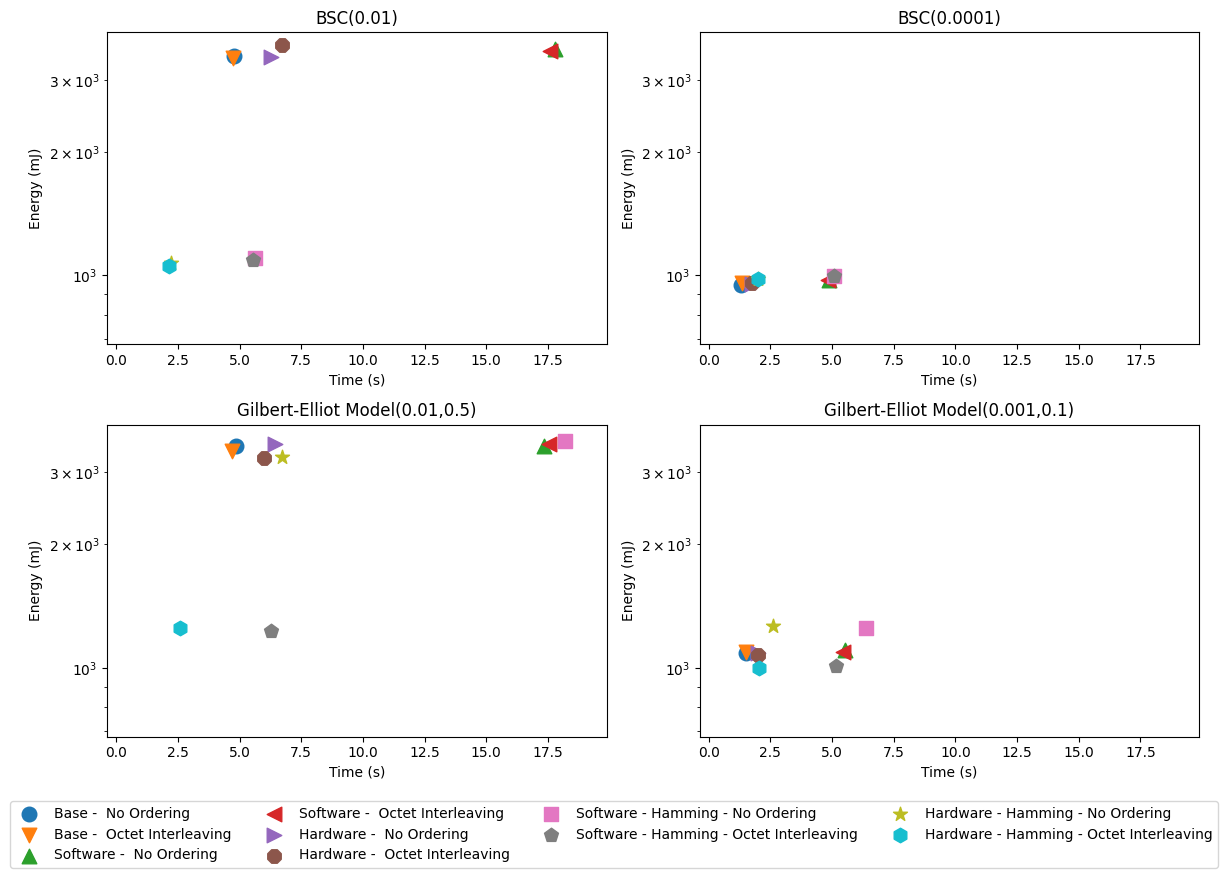

In [126]:
# create a pareto front for the energy vs time tradeoff
fig, axs = plt.subplots(2, 2, figsize=(12, 8))


# group by the noise model
groups = {
    noise_model.get_name(): list(filter(lambda x: x.noise_model == noise_model, simulation_results))
    for noise_model in noise_models
}

# minmax = lambda

min_time: float = min([min([simulation_result.total_time for simulation_result in group]) for group in groups.values()])
max_time: float = max([max([simulation_result.total_time for simulation_result in group]) for group in groups.values()])
min_energy: float = min([min([simulation_result.total_energy for simulation_result in group]) for group in groups.values()])
max_energy: float = max([max([simulation_result.total_energy for simulation_result in group]) for group in groups.values()])

time_surplus: float = (max_time - min_time) * 0.1
energy_surplus: float = (max_energy - min_energy) * 0.1

configuration_labels: List[str] = []

import matplotlib

markers = matplotlib.markers.MarkerStyle.filled_markers
print(markers)


for axis, (noise_model_name, group) in zip(axs.flatten(), groups.items()):
    axis.set_title(noise_model_name)
    axis.set_xlabel('Time (s)')
    axis.set_ylabel('Energy (mJ)')
    axis.set_xlim(min_time - time_surplus, max_time + time_surplus)
    axis.set_ylim(min_energy - energy_surplus, max_energy + energy_surplus)
    axis.semilogy()
    # axis.grid()
    
    n_groups = len(group)

    min_x = (1e12, None)
    min_y = (1e12, None)

    for simulation_result, marker in zip(group, markers[:n_groups]):
        if simulation_result.concede:
            continue
        

        min_x_before = min_x[0]
        if min_x_before == min(min_x[0], simulation_result.total_time):
            min_x = (min(min_x[0], simulation_result.total_time), simulation_result.total_energy)

        min_y_before = min_y[0]
        if min_y_before == min(min_y[0], simulation_result.total_energy):
            min_y = (min(min_y[0], simulation_result.total_energy), simulation_result.total_time)

        # min_x = (min(min_x, simulation_result.total_time)
        # min_y = min(min_y, simulation_result.total_energy)
        axis.scatter(simulation_result.total_time, simulation_result.total_energy, marker=marker, s=110)

        aes_implementation: str = 'Base'
        if simulation_result.configuration.aes_implementation is not None:
            if simulation_result.configuration.aes_implementation == AesImplementation.Hardware:
                aes_implementation = 'Hardware'
            elif simulation_result.configuration.aes_implementation == AesImplementation.Software:
                aes_implementation = 'Software'

        label = '{} - {} {}'.format(
            aes_implementation,
            'Hamming -' if simulation_result.configuration.hamming_used else '',
            simulation_result.ordering_scheme.get_name()
        )

        # print(f'{simulation_result.name} | {label}')
        # print(label)

        if label not in configuration_labels:
            configuration_labels.append(label)


    import functools as ft
    min_x_and_its_y = ft.reduce(
        lambda a, b: a if a[0] < b[0] else b, 
        map(lambda a: (a.total_time, a.total_energy), filter(lambda a: not a.concede, group)), 
        (1e12, None)
    )

    min_y_and_its_x = ft.reduce(
        lambda a, b: a if a[0] < b[0] else b,
        map(lambda a: (a.total_energy, a.total_time), filter(lambda a: not a.concede, group)),
        (1e12, None)
    )

    print('min_x_and_its_y', min_x_and_its_y)
    print('min_y_and_its_x', min_y_and_its_x)


    xlim = axis.get_xlim()
    xlim_interval = xlim[1] - xlim[0]
    ylim = axis.get_ylim()
    ylim_interval = ylim[1] - ylim[0]

    print('xlim', xlim)
    print('ylim', ylim)
    # print('y_min', min_y)
    # print('x_min', min_x)


    # x_offset: float = (xlim[1] - (xlim[1] - min_x)) / xlim[1]
    x_offset: float = (min_x[0] - 0) / xlim_interval
    # y_offset: float = (ylim[1] - (ylim[1] - min_y)) / ylim[1]
    y_offset: float = (min_y[0] - ylim[0]) / ylim_interval

    x_offset: float = (min_y_and_its_x[1] - xlim[0]) / xlim_interval
    y_offset: float = (min_x_and_its_y[1] - ylim[0]) / ylim_interval

    print('x_offset', x_offset)
    print('y_offset', y_offset)
    print('-' * 80)

    # draw vertical line from bottom axis to min_y
    # axis.axhline(min_y, color='black', linestyle='dashed', linewidth=1)
    # axis.axhline(min_y, xmin=0, xmax=0.5, color='black', linewidth=1, alpha=0.75, linestyle='--')    
    # axis.axhline(min_y_and_its_x[0], xmin=0, xmax=y_offset, color='black', linewidth=1, alpha=0.75, linestyle='--')    
    # axis.axvline(min_x_and_its_y[0], ymin=0, ymax=x_offset, color='black', linewidth=1, alpha=0.75, linestyle='--')    
    # axis.axvline(min_x, ymin=0, ymax=x_offset, color='black', linewidth=1, alpha=0.75, linestyle='--')    

# set fig.legend below the subplots
# offset it enough so that it doesn't overlap with the subplots
fig.legend(configuration_labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.1))



plt.tight_layout()

fig.savefig('../charts/energy_vs_time.png', dpi=300, bbox_inches='tight')
fig.savefig('../charts/energy_vs_time.pdf', format='pdf', dpi=300, bbox_inches='tight')


plt.show()